# Module 1

### Imports

In [91]:
import glob
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import os, random
import pathlib
from PIL import Image
import imageio
from skimage import color
from sklearn.utils import shuffle
from tqdm import tqdm

### Helper Functions

In [65]:
def display_image(ax, image, label, classes):
    ''' Display selected image.
    
    Parameters:
        ax (matplotlib.figure.Figure): figure to display images.
        image numpy.ndarray: 512 x 512 x 3.
        labels (list(numpy.int32)): 300 x 1.
        classes (list(str)): 3 x 1.
    
    Returns:
        NA: figure
        
    '''
    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(classes[label])

In [66]:
def display_images(ax, images, labels, classes, size):
    ''' Display selected images.
    
    Parameters:
        ax (matplotlib.figure.Figure): figure to display images.
        images (list(numpy.ndarray)): 300 x 512 x 512 x 3.
        labels (list(numpy.int32)): 300 x 1.
        classes (list(str)): 3 x 1.
        size (tuple): 1 x 2, dimensions of the subplot (height, width).
    
    Returns:
        NA: figure
        
    '''
    
    for i in range(0, size[0]*size[1]):
        plt.subplot(size[0], size[1], i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classes[labels[i]])

In [75]:
def save_images(save_dir, classes, images, labels):
    num_images_in_each_class = np.zeros((1, len(classes)), dtype=np.uint8)

    new_dir = save_dir
    print('Saving images in:', new_dir)
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    for i in tqdm(range(0, len(images))):
        current_class = labels[i]
        num_images_in_each_class[0, current_class] += 1 #used for incrementing file name

        curr_dir = save_dir + '\\' + str(classes[current_class]) + '_' + '{:03d}'.format(num_images_in_each_class[0, current_class]) + '.png'
        imageio.imwrite(curr_dir, images[i].astype(np.uint8))
        
#         for current_class in range(0, len(classes)):
#             new_dir = save_dir + '\\' + str(classes[current_class])
#             print('Saving images in:', new_dir)
#             if not os.path.exists(new_dir):
#                 os.makedirs(new_dir)

In [92]:
def determine_class(file_dir, classes):
    path = np.char.split(file_dir, sep ='\\')
    file_name = path.item(0)[-1]
    for i in range(0, len(classes)):
        if classes[i] in file_name:
            return i
    return -1

### Load Images

In [7]:
current_dir = os.getcwd()
data_dir = current_dir + '\data_original'
classes = os.listdir(data_dir)

original_image_size = (512, 512, 3)
original_images = np.empty((0, original_image_size[0], original_image_size[1], original_image_size[2]), dtype=np.uint8)
original_labels = np.empty((0,), dtype=np.uint8)
original_image_files = np.empty((0, 1))

for i in tqdm(range(0, len(classes))):
    print('Class ' + str(i+1) + ': ' + classes[i])
    
    class_dir = data_dir + '\\' + classes[i]
    print('Loading images from:', class_dir)
    current_image_files = glob.glob(class_dir + '/*.png')
    
    current_images = np.array([np.array(Image.open(image_file)) for image_file in current_image_files])
    current_images = current_images.astype(np.uint8)
    
    original_images = np.append(original_images, current_images, axis=0)
    original_labels = np.append(original_labels, (i * np.ones((current_images.shape[0],))).astype(int), axis=0)

    image_files = np.expand_dims(np.asarray(current_image_files), axis=1)
    original_image_files = np.append(original_image_files, image_files, axis=0)
    
print()
print('Images:', original_images.shape)
print('Labels:', original_labels.shape)
print('Files:', original_image_files.shape)

  0%|                                                                                                                                                                                                                                                   | 0/3 [00:00<?, ?it/s]

Class 1: Necrosis
Loading images from: C:\Users\alexa\Documents\GitHub\TCGA-kidney\original_data\Necrosis


 33%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 1/3 [00:02<00:05,  0.37it/s]

Class 2: Stroma
Loading images from: C:\Users\alexa\Documents\GitHub\TCGA-kidney\original_data\Stroma


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 2/3 [00:06<00:03,  0.32it/s]

Class 3: Tumor
Loading images from: C:\Users\alexa\Documents\GitHub\TCGA-kidney\original_data\Tumor



Images: (300, 512, 512, 3)
Labels: (300,)
Files: (300, 1)


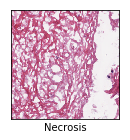

In [8]:
#display single image

ax = plt.figure(figsize=(2, 2))
display_image(ax, original_images[0], original_labels[0], classes)

In [9]:
print(classes)

['Necrosis', 'Stroma', 'Tumor']


### Implement color normalization using Reinhard's Method

In [35]:
def separate_channels(I):
    I = color.rgb2lab(I)
    I = I.astype(np.float32)
    I1, I2, I3 = (I[:, :, 0], I[:, :, 1], I[:, :, 2])
    I1 /= 2.55
    I2 -= 128.0
    I3 -= 128.0
    return I1, I2, I3

def get_mean_and_std(channels):
    mean = (np.mean(channels[0]), np.mean(channels[1]), np.mean(channels[2]))
    std = (np.std(channels[0]), np.std(channels[1]), np.std(channels[2]))
    return mean, std

def merge_channels(I1, I2, I3):
    I1 *= 2.55
    I2 += 128.0
    I3 += 128.0
    
    I = np.stack((I1, I2, I3), axis=2)
    return color.lab2rgb(I)

#fit source to target
def single_reinhard(target, source):
    target_channels = separate_channels(target)
    source_channels = separate_channels(source)
    
    source_mean, source_std = get_mean_and_std(source_channels)
    target_mean, target_std = get_mean_and_std(target_channels)
    
    modified1 = ((source_channels[0] - source_mean[0]) * (target_std[0] / source_std[0])) + target_mean[0]
    modified2 = ((source_channels[1] - source_mean[1]) * (target_std[1] / source_std[1])) + target_mean[1]
    modified3 = ((source_channels[2] - source_mean[2]) * (target_std[2] / source_std[2])) + target_mean[2]
    
    return merge_channels(modified1, modified2, modified3)*255

#### Reinhard Example

C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 584189 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


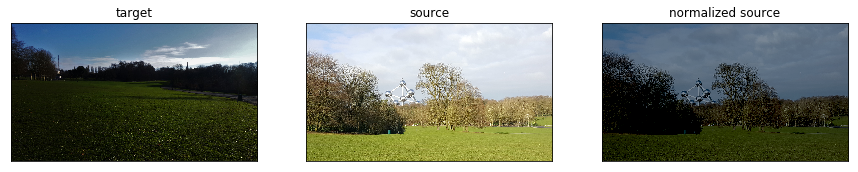

In [37]:
target = Image.open('target.jpg')
source = Image.open('source.jpg')

normalized_source_image = single_reinhard(target, source).astype(np.uint8)

ax = plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('target')
plt.imshow(target)
plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('source')
plt.imshow(source)
plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('normalized source')
plt.imshow(normalized_source_image)

#### Normalize Data

In [60]:
#TODO issue with skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0
#NOTE Will take a few minutes

normalized_images = np.empty((0, original_image_size[0], original_image_size[1], 3), dtype=np.uint8)
normalized_labels = np.empty((0,), dtype=np.uint8)

save = True

for i in range(0, len(classes)):
    class_dir = data_dir + '\\' + classes[i]
    print('Reinhard Normalization:', classes[i])
    target_image_file = random.choice(os.listdir(class_dir)) #select random target image from each class
    target_image_file = glob.glob(class_dir + '\\' + target_image_file)[0]
    print('target:', target_image_file)
    target = Image.open(target_image_file)
    
    start_index = normalized_images.shape[0]
    stop_index = start_index + original_image_files.shape[0] - 1
        
    print('%s:' % (classes[i]))
    for j in range(0, original_image_files.shape[0]):
        if j % 50 == 0:
            print('%3d / %3d' % (j, original_image_files.shape[0]))
        
        source_image_file = original_image_files[j][0]
        
        if source_image_file != target_image_file: #current source image is not the target image
            source = Image.open(source_image_file)
            
            normalized_source_image = single_reinhard(target, source).astype(np.uint8)            
            normalized_source_image = np.expand_dims(normalized_source_image, axis=0)
            normalized_images = np.append(normalized_images, normalized_source_image, axis=0)
            
            normalized_source_image_label = determine_class(source_image_file, classes) #get class of source image
            normalized_source_image_label = np.expand_dims(normalized_source_image_label, axis=0)
            normalized_labels = np.append(normalized_labels, normalized_source_image_label, axis=0)

    if save:
        #save in seperate folder according to target image class
        save_dir = current_dir + '\\data_normalized\\data_normalized_' + classes[i] + '_target'
        save_images(save_dir, classes, normalized_images[start_index:stop_index], normalized_labels[start_index:stop_index]) #save images of current batch

    print()
        
print('Normalized Images:', normalized_images.shape)
print('Normalized Labels:', normalized_labels.shape)

Reinhard Normalization: Necrosis
target: C:\Users\alexa\Documents\GitHub\TCGA-kidney\original_data\Necrosis\Necrosis_93.png
Necrosis:
  0 / 300


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 88 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages

 50 / 300


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 667 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 11 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 23 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 1148 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-pa

100 / 300


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 18 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 26 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 36 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 785 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-pack

150 / 300


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 352 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 19 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 3 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 427 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-pack

200 / 300


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 35 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 115 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


250 / 300


  0%|▊                                                                                                                                                                                                                                        | 1/299 [00:00<00:41,  7.27it/s]

Saving images in: C:\Users\alexa\Documents\GitHub\TCGA-kidney\normalized_data\normalized_data_Necrosis_target



Reinhard Normalization: Stroma
target: C:\Users\alexa\Documents\GitHub\TCGA-kidney\original_data\Stroma\Stroma_1.png
Stroma:
  0 / 300
 50 / 300
100 / 300
150 / 300
200 / 300
250 / 300


  0%|                                                                                                                                                                                                                                                 | 0/299 [00:00<?, ?it/s]

Saving images in: C:\Users\alexa\Documents\GitHub\TCGA-kidney\normalized_data\normalized_data_Stroma_target



Reinhard Normalization: Tumor
target: C:\Users\alexa\Documents\GitHub\TCGA-kidney\original_data\Tumor\Tumor_94.png
Tumor:
  0 / 300


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 65 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 125 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 64 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


 50 / 300


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 453 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 457 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 85 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 77 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-pac

100 / 300


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 135 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 203 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


150 / 300


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 247 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\color\colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 68 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


200 / 300
250 / 300


  0%|▊                                                                                                                                                                                                                                        | 1/299 [00:00<00:43,  6.79it/s]

Saving images in: C:\Users\alexa\Documents\GitHub\TCGA-kidney\normalized_data\normalized_data_Tumor_target



Normalized Images: (897, 512, 512, 3)
Normalized Labels: (897,)


#### View Sampled Normalized Data

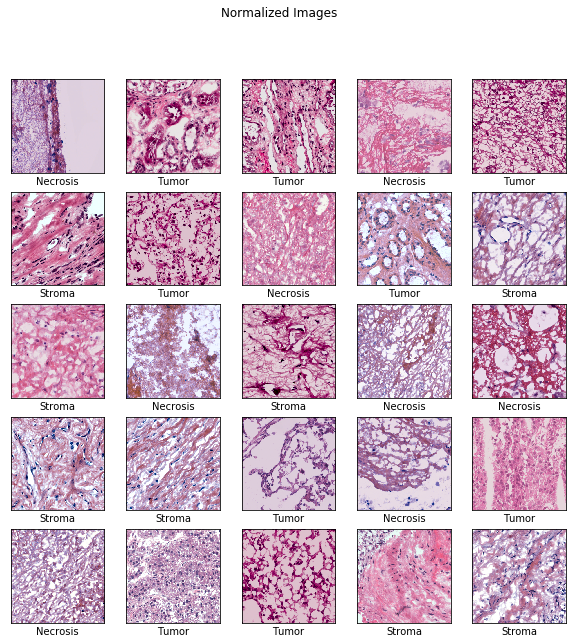

In [63]:
grid = (5, 5)
indices = np.random.choice(range(np.shape(normalized_images)[0]), grid[0]*grid[1], replace=False)

ax = plt.figure(figsize=(10, 10))
plt.suptitle('Normalized Images')
display_images(ax, normalized_images[indices], normalized_labels[indices], classes, grid)

### Apply data augmentation: random crop (224x224), flip, rotation

In [78]:
crop_size = (224, 224)
num_augmentations_per_image = 4 #NOTE adjustable
num_orientations = 4

augmented_images = np.empty((0, crop_size[0], crop_size[1], 3), dtype=np.uint8)
augmented_labels = np.empty((0,), dtype=np.uint8)

for i in tqdm(range(0, normalized_images.shape[0])):
    for _ in range(0, num_augmentations_per_image):
        flip = np.random.randint(0, 3)
        degrees = int(360 * np.random.randint(0, num_orientations) / num_orientations)

#         print('Flip:', flip, 'Degrees:', degrees)
        
        flipped_image = np.zeros((original_image_size), dtype=np.uint8)
        temp = np.zeros((original_image_size), dtype=np.uint8)
        augmented_image = np.zeros((original_image_size), dtype=np.uint8)
        
        #flip
        if flip is 0: #don't modifiy
            flipped_image = normalized_images[i, :, :, :]
        elif flip is 1: #flip vertically
            flipped_image[::-1, :, :] = normalized_images[i, :, :, :]
        elif flip is 2: #flip horizontally
            flipped_image[:, ::-1, :] = normalized_images[i, :, :, :]
        else:
            print('invalid flip selection')
        
        #https://stackoverflow.com/questions/42519/how-do-you-rotate-a-two-dimensional-array
        #rotate CCW
        if degrees == 0:
            augmented_image = flipped_image
        elif degrees == 90:
            temp = np.transpose(flipped_image, axes=(1, 0, 2)) #transpose, don't modify axis 3
            augmented_image[::-1, :, :] = temp #flip rows
        elif degrees == 180:
            temp[::-1, :, :] = flipped_image #flip rows
            augmented_image[:, ::-1, :] = temp #flip columns
        elif degrees == 270: #-90
            temp = np.transpose(flipped_image, axes=(1, 0, 2)) #transpose, don't modify axis 3
            augmented_image[:, ::-1, :] = temp #flip columns
        else:
            print('invalid rotate selection')
        
        #crop
        (r, c) = (np.random.randint(0, original_image_size[0] - crop_size[0]), np.random.randint(0, original_image_size[1] - crop_size[1]))
        augmented_image = np.expand_dims(augmented_image[r:r+crop_size[0], c:c+crop_size[1]], axis=0) #1 x crop_size[0] x crop_size[1] x 3
        
        augmented_images = np.append(augmented_images, augmented_image, axis=0)
        augmented_labels = np.append(augmented_labels, np.expand_dims(normalized_labels[i], axis=0), axis=0)

print()
print('Augmented Images:', augmented_images.shape)
print('Augmented Labels:', augmented_labels.shape)


Augmented Images: (3588, 224, 224, 3)
Augmented Labels: (3588,)


#### View Sampled  Augmented Data

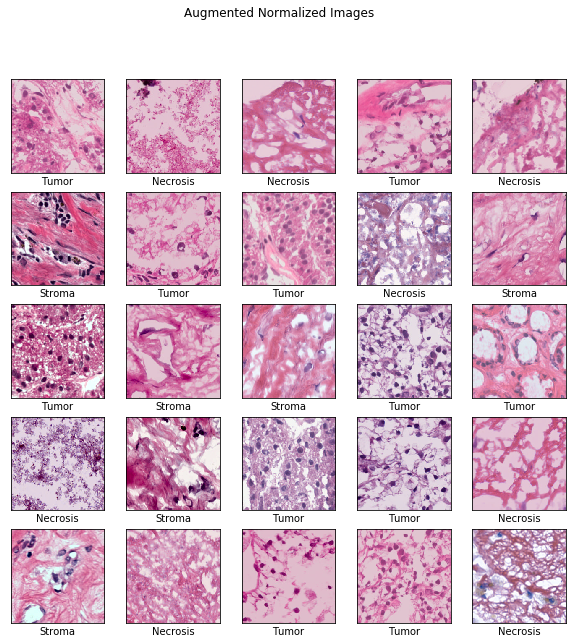

In [80]:
grid = (5, 5)
indices = np.random.choice(range(np.shape(augmented_images)[0]), grid[0]*grid[1], replace=False)

ax = plt.figure(figsize=(10, 10))
plt.suptitle('Augmented Normalized Images')
display_images(ax, augmented_images[indices], augmented_labels[indices], classes, grid)

#### Save Augmented Data

In [81]:
#save all in one folder

save_dir = current_dir + '\\data_augmented'
save_images(save_dir, classes, augmented_images, augmented_labels)

  0%|▎                                                                                                                                                                                                                                       | 4/3588 [00:00<01:34, 38.12it/s]

Saving images in: C:\Users\alexa\Documents\GitHub\TCGA-kidney\data_augmented


### Randomize Image Order

In [14]:
# ax = plt.figure(figsize=(10, 10))
# plt.suptitle('Preshuffle')
# display_images(ax, images, labels, classes, (5, 5))

# images, labels = shuffle(images, labels)

# ax = plt.figure(figsize=(10, 10))
# plt.suptitle('Postshuffle')
# display_images(ax, images, labels, classes, (5, 5))

In [89]:
# import cv2

# num = 201

# ax = plt.figure(figsize=(5, 5))
# display_image(ax, original_images[num], original_labels[num], classes)

# image_hsv = cv2.cvtColor(original_images[num], cv2.COLOR_BGR2HSV) #convert BGR to HSV

# (hue_channel, saturation_channel, value_channel) = cv2.split(image_hsv) #split into 3 channels

# ax2 = plt.figure(figsize=(10, 10))
# plt.subplot(1, 3, 1)
# plt.imshow(cv2.cvtColor(hue_channel, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.subplot(1, 3, 2)
# plt.imshow(cv2.cvtColor(saturation_channel, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.subplot(1, 3, 3)
# plt.imshow(cv2.cvtColor(value_channel, cv2.COLOR_BGR2RGB))
# plt.axis('off')